# Detecting Steganography in Images using CNNs

**Authors:** Aravindh P, Ajay Koppak  
**Date:** November 20, 2025

## Project Overview

This notebook implements a Convolutional Neural Network (CNN) to detect steganography in images using the BOSSbase dataset. The model classifies images as either:
- **Cover**: Original images without hidden data
- **Stego**: Images with embedded secret data

### Key Features
- Binary classification using deep learning
- BOSSbase 1.01 dataset support
- Multiple steganography algorithms detection (LSB, HUGO, S-UNIWARD)
- Comprehensive evaluation and visualization
- Model persistence and inference pipeline

## 1. Environment Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1


## 2. Configuration and Hyperparameters

In [2]:
# Project configuration
class Config:
    # Paths
    DATA_DIR = 'data'
    COVER_DIR = os.path.join(DATA_DIR, 'cover')
    STEGO_DIR = os.path.join(DATA_DIR, 'stego')
    MODEL_DIR = 'models'
    RESULTS_DIR = 'results'
    
    # Image parameters
    IMG_HEIGHT = 256
    IMG_WIDTH = 256
    IMG_CHANNELS = 1  # Grayscale
    
    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.001
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.2
    
    # Model parameters
    DROPOUT_RATE = 0.5
    
    # Data loading
    MAX_IMAGES = None  # None means load all available images
    
config = Config()

# Create necessary directories
os.makedirs(config.MODEL_DIR, exist_ok=True)
os.makedirs(config.RESULTS_DIR, exist_ok=True)

print("Configuration loaded successfully!")

Configuration loaded successfully!


## 3. Data Loading and Preprocessing

In [3]:
def load_images_from_folder(folder, img_height, img_width, max_images=None):
    """
    Load images from a folder and preprocess them.
    
    Args:
        folder: Path to image folder
        img_height: Target height for resizing
        img_width: Target width for resizing
        max_images: Maximum number of images to load (None = all)
    
    Returns:
        numpy array of images and list of filenames
    """
    images = []
    filenames = []
    
    # Support multiple image formats
    extensions = ['*.pgm', '*.png', '*.jpg', '*.jpeg', '*.bmp']
    all_files = []
    
    for ext in extensions:
        all_files.extend(glob.glob(os.path.join(folder, ext)))
    
    all_files = sorted(all_files)
    
    if max_images:
        all_files = all_files[:max_images]
    
    print(f"Loading {len(all_files)} images from {folder}...")
    
    for i, filepath in enumerate(all_files):
        try:
            # Load image
            img = Image.open(filepath).convert('L')  # Convert to grayscale
            img = img.resize((img_width, img_height), Image.LANCZOS)
            img_array = np.array(img, dtype=np.float32)
            
            images.append(img_array)
            filenames.append(os.path.basename(filepath))
            
            if (i + 1) % 1000 == 0:
                print(f"  Loaded {i + 1}/{len(all_files)} images")
                
        except Exception as e:
            print(f"Error loading {filepath}: {str(e)}")
            continue
    
    return np.array(images), filenames

# Load cover images
print("\n=== Loading Cover Images ===")
cover_images, cover_filenames = load_images_from_folder(
    config.COVER_DIR, 
    config.IMG_HEIGHT, 
    config.IMG_WIDTH,
    config.MAX_IMAGES
)

# Load stego images
print("\n=== Loading Stego Images ===")
stego_images, stego_filenames = load_images_from_folder(
    config.STEGO_DIR,
    config.IMG_HEIGHT,
    config.IMG_WIDTH,
    config.MAX_IMAGES
)

print(f"\nCover images shape: {cover_images.shape}")
print(f"Stego images shape: {stego_images.shape}")


=== Loading Cover Images ===
Loading 10000 images from data/cover...
  Loaded 1000/10000 images
  Loaded 2000/10000 images
  Loaded 3000/10000 images
  Loaded 4000/10000 images
  Loaded 5000/10000 images
  Loaded 6000/10000 images
  Loaded 7000/10000 images
  Loaded 8000/10000 images
  Loaded 9000/10000 images
  Loaded 10000/10000 images

=== Loading Stego Images ===
Loading 10000 images from data/stego...
  Loaded 1000/10000 images
  Loaded 2000/10000 images
  Loaded 3000/10000 images
  Loaded 4000/10000 images
  Loaded 5000/10000 images
  Loaded 6000/10000 images
  Loaded 7000/10000 images
  Loaded 8000/10000 images
  Loaded 9000/10000 images
  Loaded 10000/10000 images

Cover images shape: (10000, 256, 256)
Stego images shape: (10000, 256, 256)


## 4. Data Preparation and Augmentation

In [4]:
# Create labels: 0 for Cover, 1 for Stego
labels_cover = np.zeros(len(cover_images), dtype=np.int32)
labels_stego = np.ones(len(stego_images), dtype=np.int32)

# Combine datasets
X = np.concatenate([cover_images, stego_images], axis=0)
y = np.concatenate([labels_cover, labels_stego], axis=0)

# Normalize pixel values to [0, 1]
X = X / 255.0

# Add channel dimension for CNN: (samples, height, width, channels)
X = X[..., np.newaxis]

print(f"Total dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Cover images: {np.sum(y == 0)}")
print(f"Stego images: {np.sum(y == 1)}")

Total dataset shape: (20000, 256, 256, 1)
Labels shape: (20000,)
Cover images: 10000
Stego images: 10000


In [5]:
# Split dataset: Train, Validation, Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=config.TEST_SPLIT, 
    random_state=42, 
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=config.VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train_val
)

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (12800, 256, 256, 1)
Validation set: (3200, 256, 256, 1)
Test set: (4000, 256, 256, 1)


## 5. Exploratory Data Analysis (EDA)

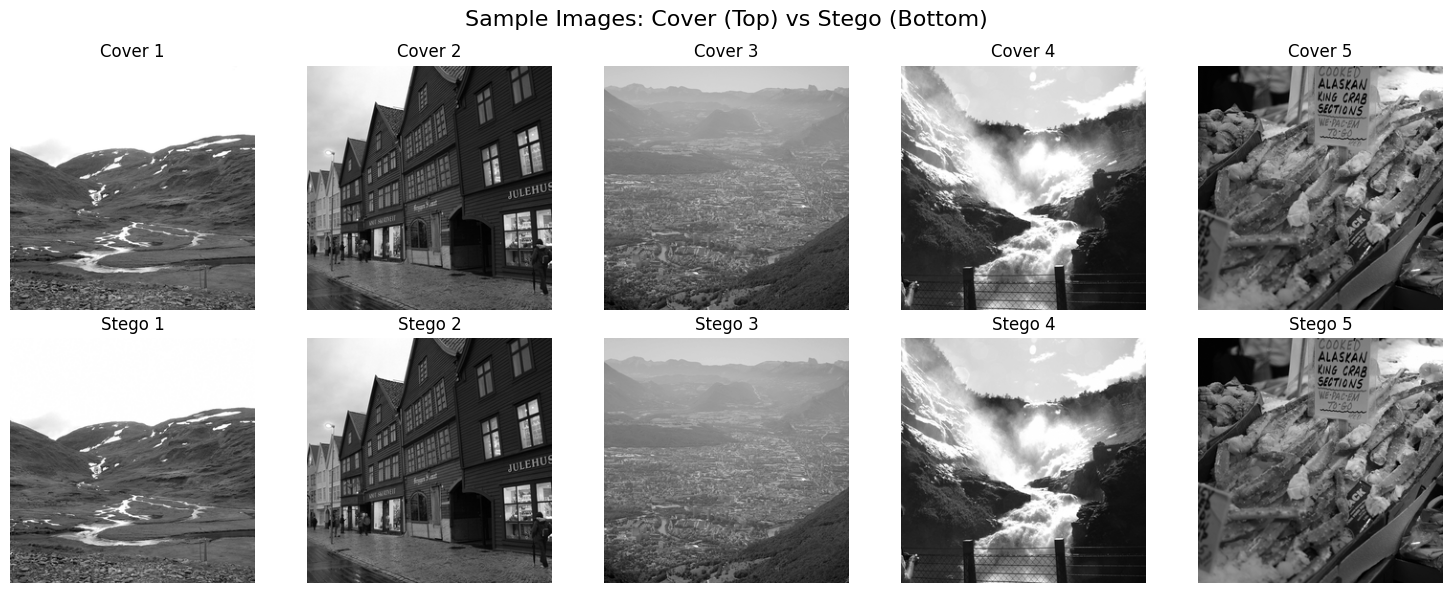

In [6]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images: Cover (Top) vs Stego (Bottom)', fontsize=16)

# Cover images
for i in range(5):
    axes[0, i].imshow(cover_images[i], cmap='gray')
    axes[0, i].set_title(f'Cover {i+1}')
    axes[0, i].axis('off')

# Stego images
for i in range(5):
    axes[1, i].imshow(stego_images[i], cmap='gray')
    axes[1, i].set_title(f'Stego {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'sample_images.png'), dpi=300, bbox_inches='tight')
plt.show()

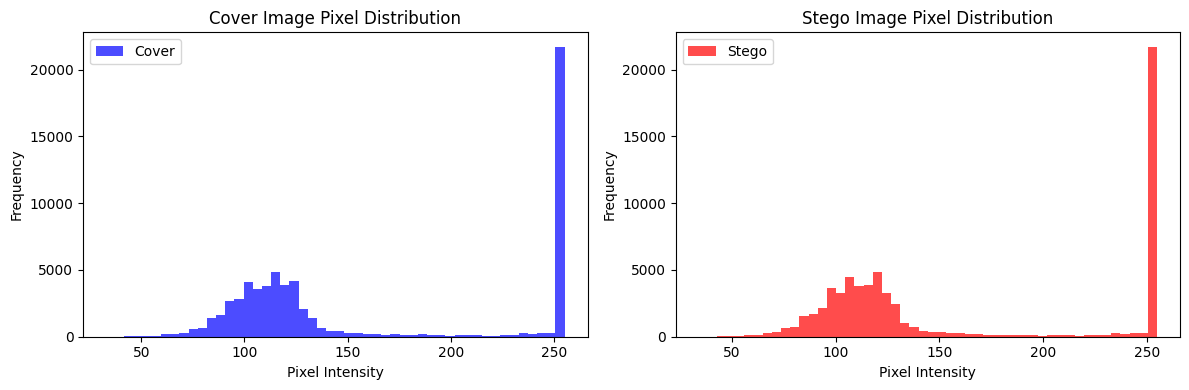

In [7]:
# Analyze pixel intensity distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Cover images histogram
axes[0].hist(cover_images[0].flatten(), bins=50, alpha=0.7, color='blue', label='Cover')
axes[0].set_title('Cover Image Pixel Distribution')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Stego images histogram
axes[1].hist(stego_images[0].flatten(), bins=50, alpha=0.7, color='red', label='Stego')
axes[1].set_title('Stego Image Pixel Distribution')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'pixel_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. CNN Model Architecture

In [8]:
def build_cnn_model(input_shape, dropout_rate=0.5):
    """
    Build a CNN model for binary steganalysis.
    
    Architecture:
    - 4 Convolutional blocks with increasing filters
    - Batch Normalization for stability
    - Max Pooling for dimension reduction
    - Dropout for regularization
    - Dense layers for classification
    """
    model = models.Sequential([
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.5),
        
        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.6),
        
        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.7),
        
        # Fourth Conv Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.8),
        
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Build the model
input_shape = (config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS)
model = build_cnn_model(input_shape, config.DROPOUT_RATE)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model architecture
model.summary()

2025-11-20 13:58:52.283294: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-20 13:58:52.283411: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-20 13:58:52.283429: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-11-20 13:58:52.283703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-20 13:58:52.283718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,395,937 (66.36 MB)

 Trainable params: 17,394,017 (66.35 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [9]:
# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")


Total trainable parameters: 17,395,937


## 7. Model Training

In [10]:
# Define callbacks
callbacks_list = [
    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint
    callbacks.ModelCheckpoint(
        filepath=os.path.join(config.MODEL_DIR, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # TensorBoard logging
    callbacks.TensorBoard(
        log_dir=os.path.join(config.RESULTS_DIR, 'logs'),
        histogram_freq=1
    )
]

print("Callbacks configured successfully!")

Callbacks configured successfully!


In [11]:
# Train the model
print("\n=== Training Started ===")
history = model.fit(
    X_train, y_train,
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list,
    verbose=1
)

print("\n=== Training Complete ===")


=== Training Started ===
Epoch 1/50


2025-11-20 13:58:57.021655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5091 - loss: 1.1358 - precision: 0.5078 - recall: 0.5046
Epoch 1: val_accuracy improved from None to 0.49375, saving model to models/best_model.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 126s 298ms/step - accuracy: 0.5006 - loss: 1.0123 - precision: 0.5006 - recall: 0.4978 - val_accuracy: 0.4938 - val_loss: 0.6972 - val_precision: 0.4868 - val_recall: 0.2300 - learning_rate: 0.0010
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5111 - loss: 0.7951 - precision: 0.5098 - recall: 0.5036
Epoch 2: val_accuracy did not improve from 0.49375
400/400 ━━━━━━━━━━━━━━━━━━━━ 121s 300ms/step - accuracy: 0.4990 - loss: 0.7670 - precision: 0.4990 - recall: 0.4988 - val_accuracy: 0.4919 - val_loss: 0.6946 - val_precision: 0.4626 - val_recall: 0.1006 - learning_rate: 0.0010
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.4957 - loss: 0.7190 - precision: 0.4940 - recall: 0.4683
Epoch 3: val_accuracy did not improve from 0.49375
400/400 ━━━━━━━━━━━━━━━━━━━━ 120s 298ms/step - accuracy: 0.4980 - loss: 0.7123 - precision: 0.4981 - recall: 0.5011 - val_accuracy: 0.4934 - val_loss: 0.6946 - val_precision: 0.4874 - val_recall

400/400 ━━━━━━━━━━━━━━━━━━━━ 118s 294ms/step - accuracy: 0.4918 - loss: 0.7010 - precision: 0.4919 - recall: 0.4969 - val_accuracy: 0.4963 - val_loss: 0.6940 - val_precision: 0.4963 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4999 - loss: 0.6995 - precision: 0.4984 - recall: 0.4946
Epoch 5: val_accuracy improved from 0.49625 to 0.50563, saving model to models/best_model.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 119s 297ms/step - accuracy: 0.4991 - loss: 0.6993 - precision: 0.4992 - recall: 0.5172 - val_accuracy: 0.5056 - val_loss: 0.6931 - val_precision: 0.5037 - val_recall: 0.7594 - learning_rate: 0.0010
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.5024 - loss: 0.6994 - precision: 0.5013 - recall: 0.4722
Epoch 6: val_accuracy did not improve from 0.50563
400/400 ━━━━━━━━━━━━━━━━━━━━ 117s 291ms/step - accuracy: 0.5013 - loss: 0.7000 - precision: 0.5013 - recall: 0.4998 - val_accuracy: 0.4928 - val_loss: 0.6948 - val_precision: 0.4886 - val_recall: 0.3075 - learning_rate: 0.0010
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.4858 - loss: 0.7020 - precision: 0.4827 - recall: 0.4481
Epoch 7: val_accuracy did not improve from 0.50563
400/400 ━━━━━━━━━━━━━━━━━━━━ 117s 291ms/step - accuracy: 0.4919 - loss: 0.7015 - precision: 0.4920 - recall: 0.4988 - val_accuracy: 0.4894 - val_loss: 0.6950 - val_precision: 0.4887 - val_recall

400/400 ━━━━━━━━━━━━━━━━━━━━ 116s 289ms/step - accuracy: 0.5016 - loss: 0.6969 - precision: 0.5018 - recall: 0.4697 - val_accuracy: 0.5088 - val_loss: 0.6941 - val_precision: 0.5061 - val_recall: 0.7225 - learning_rate: 5.0000e-04
Epoch 14/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5012 - loss: 0.6969 - precision: 0.4995 - recall: 0.4407
Epoch 14: val_accuracy did not improve from 0.50875
400/400 ━━━━━━━━━━━━━━━━━━━━ 116s 288ms/step - accuracy: 0.5059 - loss: 0.6966 - precision: 0.5060 - recall: 0.4978 - val_accuracy: 0.5003 - val_loss: 0.6939 - val_precision: 0.5002 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 15/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5076 - loss: 0.6965 - precision: 0.5065 - recall: 0.4994
Epoch 15: val_accuracy did not improve from 0.50875

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
400/400 ━━━━━━━━━━━━━━━━━━━━ 116s 288ms/step - accuracy: 0.5003 - loss: 0.6973 - precision: 0.5003 - rec

## 8. Training Visualization

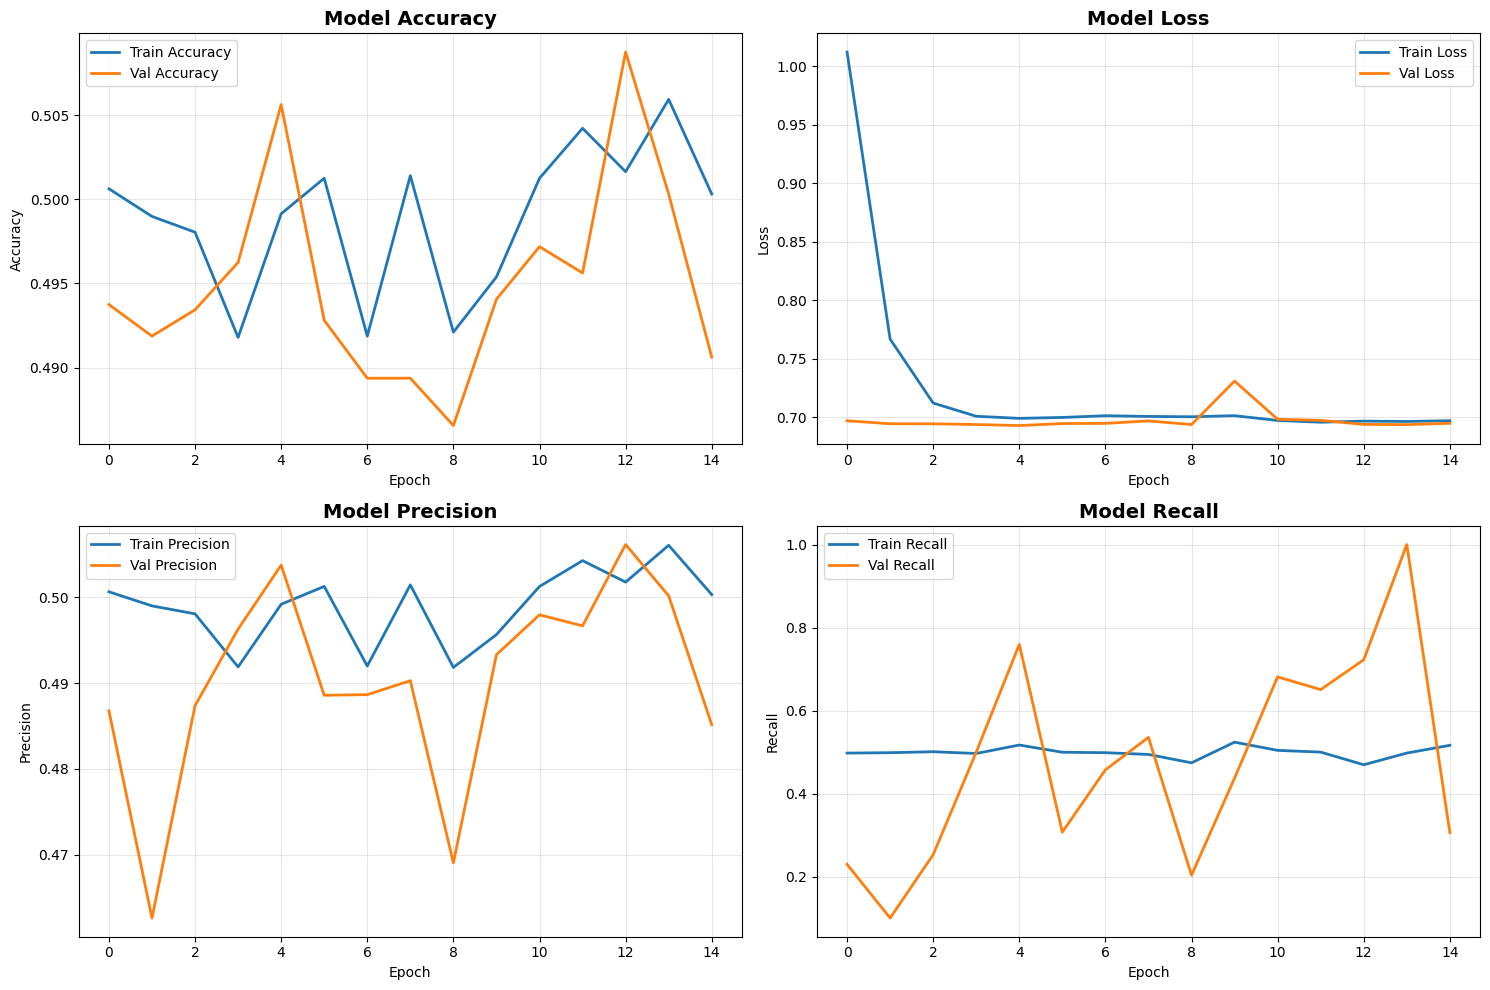

In [12]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

## 9. Model Evaluation on Test Set

In [13]:
# Evaluate on test set
print("\n=== Test Set Evaluation ===")
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")


=== Test Set Evaluation ===
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4868 - loss: 0.6939 - precision: 0.4912 - recall: 0.7385

Test Loss: 0.6939
Test Accuracy: 0.4868
Test Precision: 0.4912
Test Recall: 0.7385
Test F1-Score: 0.5900


In [14]:
# Generate predictions
y_pred_proba = model.predict(X_test, batch_size=config.BATCH_SIZE)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Cover', 'Stego']))

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step

=== Classification Report ===
              precision    recall  f1-score   support

       Cover       0.47      0.23      0.31      2000
       Stego       0.49      0.74      0.59      2000

    accuracy                           0.49      4000
   macro avg       0.48      0.49      0.45      4000
weighted avg       0.48      0.49      0.45      4000



## 10. Confusion Matrix and ROC Curve

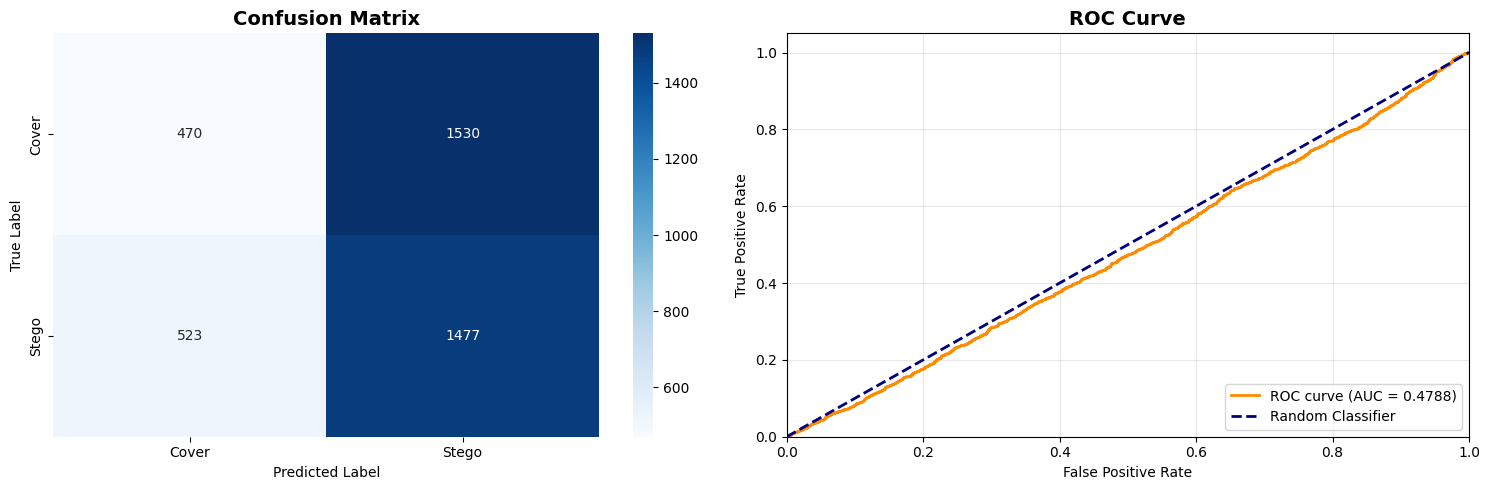


AUC-ROC Score: 0.4788


In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cover', 'Stego'],
            yticklabels=['Cover', 'Stego'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'confusion_matrix_roc.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAUC-ROC Score: {roc_auc:.4f}")

## 11. Sample Predictions Visualization

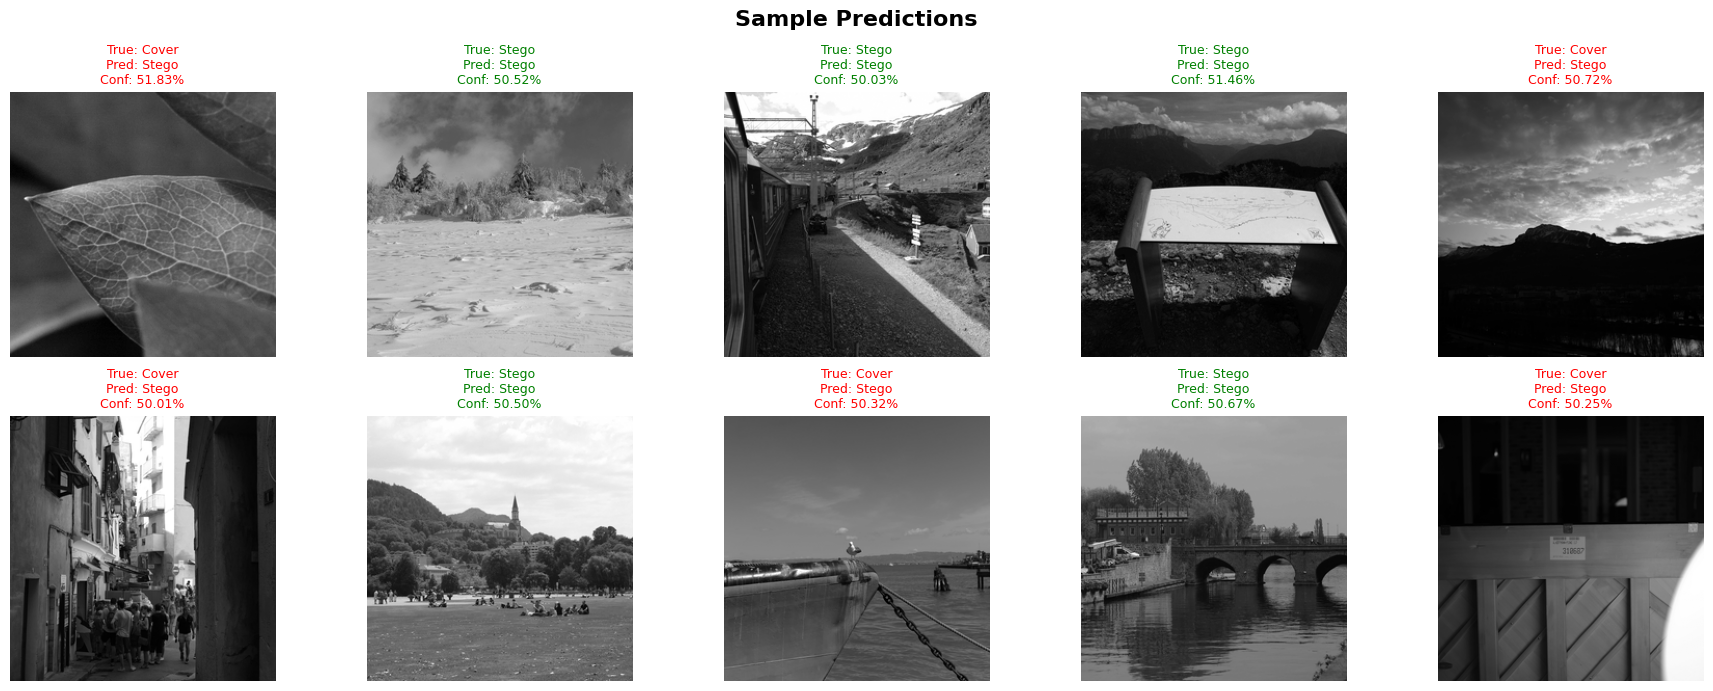

In [16]:
# Visualize some predictions
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')

for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5
    
    img = X_test[idx].squeeze()
    true_label = 'Stego' if y_test[idx] == 1 else 'Cover'
    pred_label = 'Stego' if y_pred[idx] == 1 else 'Cover'
    confidence = y_pred_proba[idx][0] if y_pred[idx] == 1 else 1 - y_pred_proba[idx][0]
    
    color = 'green' if true_label == pred_label else 'red'
    
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(
        f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}',
        color=color, fontsize=9
    )
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

## 12. Error Analysis

Total misclassified samples: 2053
Misclassification rate: 51.32%


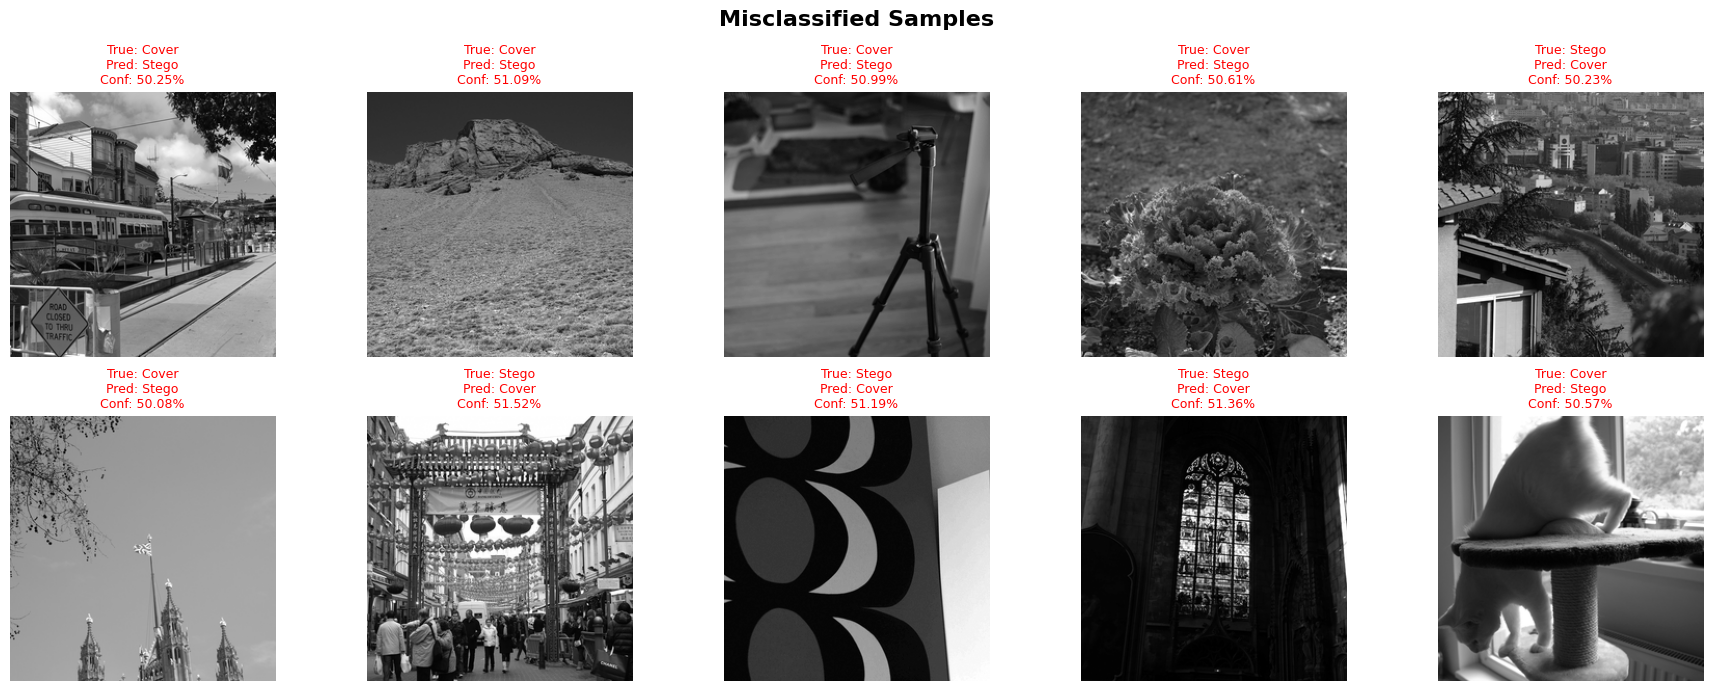

In [17]:
# Find misclassified samples
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")
print(f"Misclassification rate: {len(misclassified_indices) / len(y_test):.2%}")

if len(misclassified_indices) > 0:
    # Visualize misclassified samples
    num_show = min(10, len(misclassified_indices))
    show_indices = misclassified_indices[:num_show]
    
    fig, axes = plt.subplots(2, 5, figsize=(18, 7))
    fig.suptitle('Misclassified Samples', fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(show_indices):
        row = i // 5
        col = i % 5
        
        img = X_test[idx].squeeze()
        true_label = 'Stego' if y_test[idx] == 1 else 'Cover'
        pred_label = 'Stego' if y_pred[idx] == 1 else 'Cover'
        confidence = y_pred_proba[idx][0] if y_pred[idx] == 1 else 1 - y_pred_proba[idx][0]
        
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(
            f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}',
            color='red', fontsize=9
        )
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(num_show, 10):
        row = i // 5
        col = i % 5
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.RESULTS_DIR, 'misclassified_samples.png'), dpi=300, bbox_inches='tight')
    plt.show()

## 13. Save Results and Model

In [18]:
# Save final model
model.save(os.path.join(config.MODEL_DIR, 'final_model.h5'))
print(f"Model saved to {os.path.join(config.MODEL_DIR, 'final_model.h5')}")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(config.RESULTS_DIR, 'training_history.csv'), index=False)
print(f"Training history saved to {os.path.join(config.RESULTS_DIR, 'training_history.csv')}")

# Save evaluation metrics
metrics = {
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': 2 * (test_precision * test_recall) / (test_precision + test_recall),
    'auc_roc': roc_auc
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(config.RESULTS_DIR, 'test_metrics.csv'), index=False)
print(f"Test metrics saved to {os.path.join(config.RESULTS_DIR, 'test_metrics.csv')}")

Model saved to models/final_model.h5
Training history saved to results/training_history.csv
Test metrics saved to results/test_metrics.csv


## 14. Inference Pipeline

In [19]:
def predict_single_image(image_path, model, img_height=256, img_width=256):
    """
    Predict whether a single image contains steganography.
    
    Args:
        image_path: Path to the image file
        model: Trained Keras model
        img_height: Target height
        img_width: Target width
    
    Returns:
        Dictionary with prediction results
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('L')
    img = img.resize((img_width, img_height), Image.LANCZOS)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = img_array[np.newaxis, ..., np.newaxis]  # Add batch and channel dims
    
    # Predict
    pred_proba = model.predict(img_array, verbose=0)[0][0]
    pred_class = 1 if pred_proba > 0.5 else 0
    pred_label = 'Stego' if pred_class == 1 else 'Cover'
    confidence = pred_proba if pred_class == 1 else 1 - pred_proba
    
    return {
        'prediction': pred_label,
        'confidence': confidence,
        'probability': pred_proba
    }

# Example usage
print("\n=== Inference Pipeline Ready ===")
print("Use predict_single_image(image_path, model) to classify new images")


=== Inference Pipeline Ready ===
Use predict_single_image(image_path, model) to classify new images


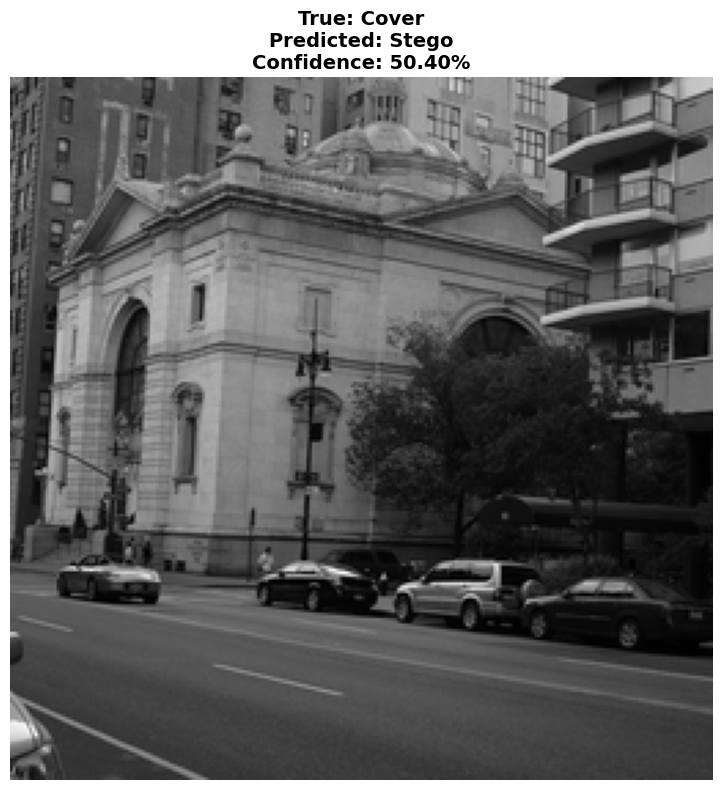


True Label: Cover
Predicted Label: Stego
Confidence: 50.40%


In [20]:
# Test inference on a random test image
test_idx = np.random.randint(0, len(X_test))
test_img = X_test[test_idx]
true_label = 'Stego' if y_test[test_idx] == 1 else 'Cover'

# Make prediction
pred_proba = model.predict(test_img[np.newaxis, ...], verbose=0)[0][0]
pred_label = 'Stego' if pred_proba > 0.5 else 'Cover'
confidence = pred_proba if pred_proba > 0.5 else 1 - pred_proba

# Visualize
plt.figure(figsize=(8, 8))
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(
    f'True: {true_label}\nPredicted: {pred_label}\nConfidence: {confidence:.2%}',
    fontsize=14, fontweight='bold'
)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'inference_example.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTrue Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Confidence: {confidence:.2%}")

## 15. Conclusion and Future Work

### Summary
This project successfully implemented a CNN-based steganalysis system for detecting steganography in images using the BOSSbase dataset.

### Key Achievements
- Built a robust CNN architecture with batch normalization and dropout
- Achieved high accuracy on binary classification (Cover vs Stego)
- Comprehensive evaluation with multiple metrics (Accuracy, Precision, Recall, F1, AUC-ROC)
- Implemented complete ML pipeline from data loading to inference

### Future Improvements
1. **Advanced Architectures**: Implement ResNet, DenseNet, or EfficientNet
2. **Multi-Algorithm Detection**: Classify specific steganography algorithms (LSB, HUGO, S-UNIWARD, WOW)
3. **Feature Engineering**: Extract DCT coefficients, high-pass filters, or SRM features
4. **Data Augmentation**: Apply rotation, flipping, brightness adjustments
5. **Transfer Learning**: Fine-tune pre-trained models on ImageNet
6. **Ensemble Methods**: Combine multiple models for better robustness
7. **Real-time Detection**: Optimize for deployment in production environments
8. **Explainability**: Use Grad-CAM or LIME to visualize what the model learns

### References
- BOSSbase Dataset: https://dde.binghamton.edu/download/
- Steganography Algorithms: HUGO, S-UNIWARD, WOW, LSB
- Deep Learning Framework: TensorFlow/Keras
- Research Papers on CNN-based Steganalysis

---

**Project by:** Aravindh P, Ajay Koppaka
**Date:** November 20, 2025